# Project #1: Gender Image Classification with TensorFlow

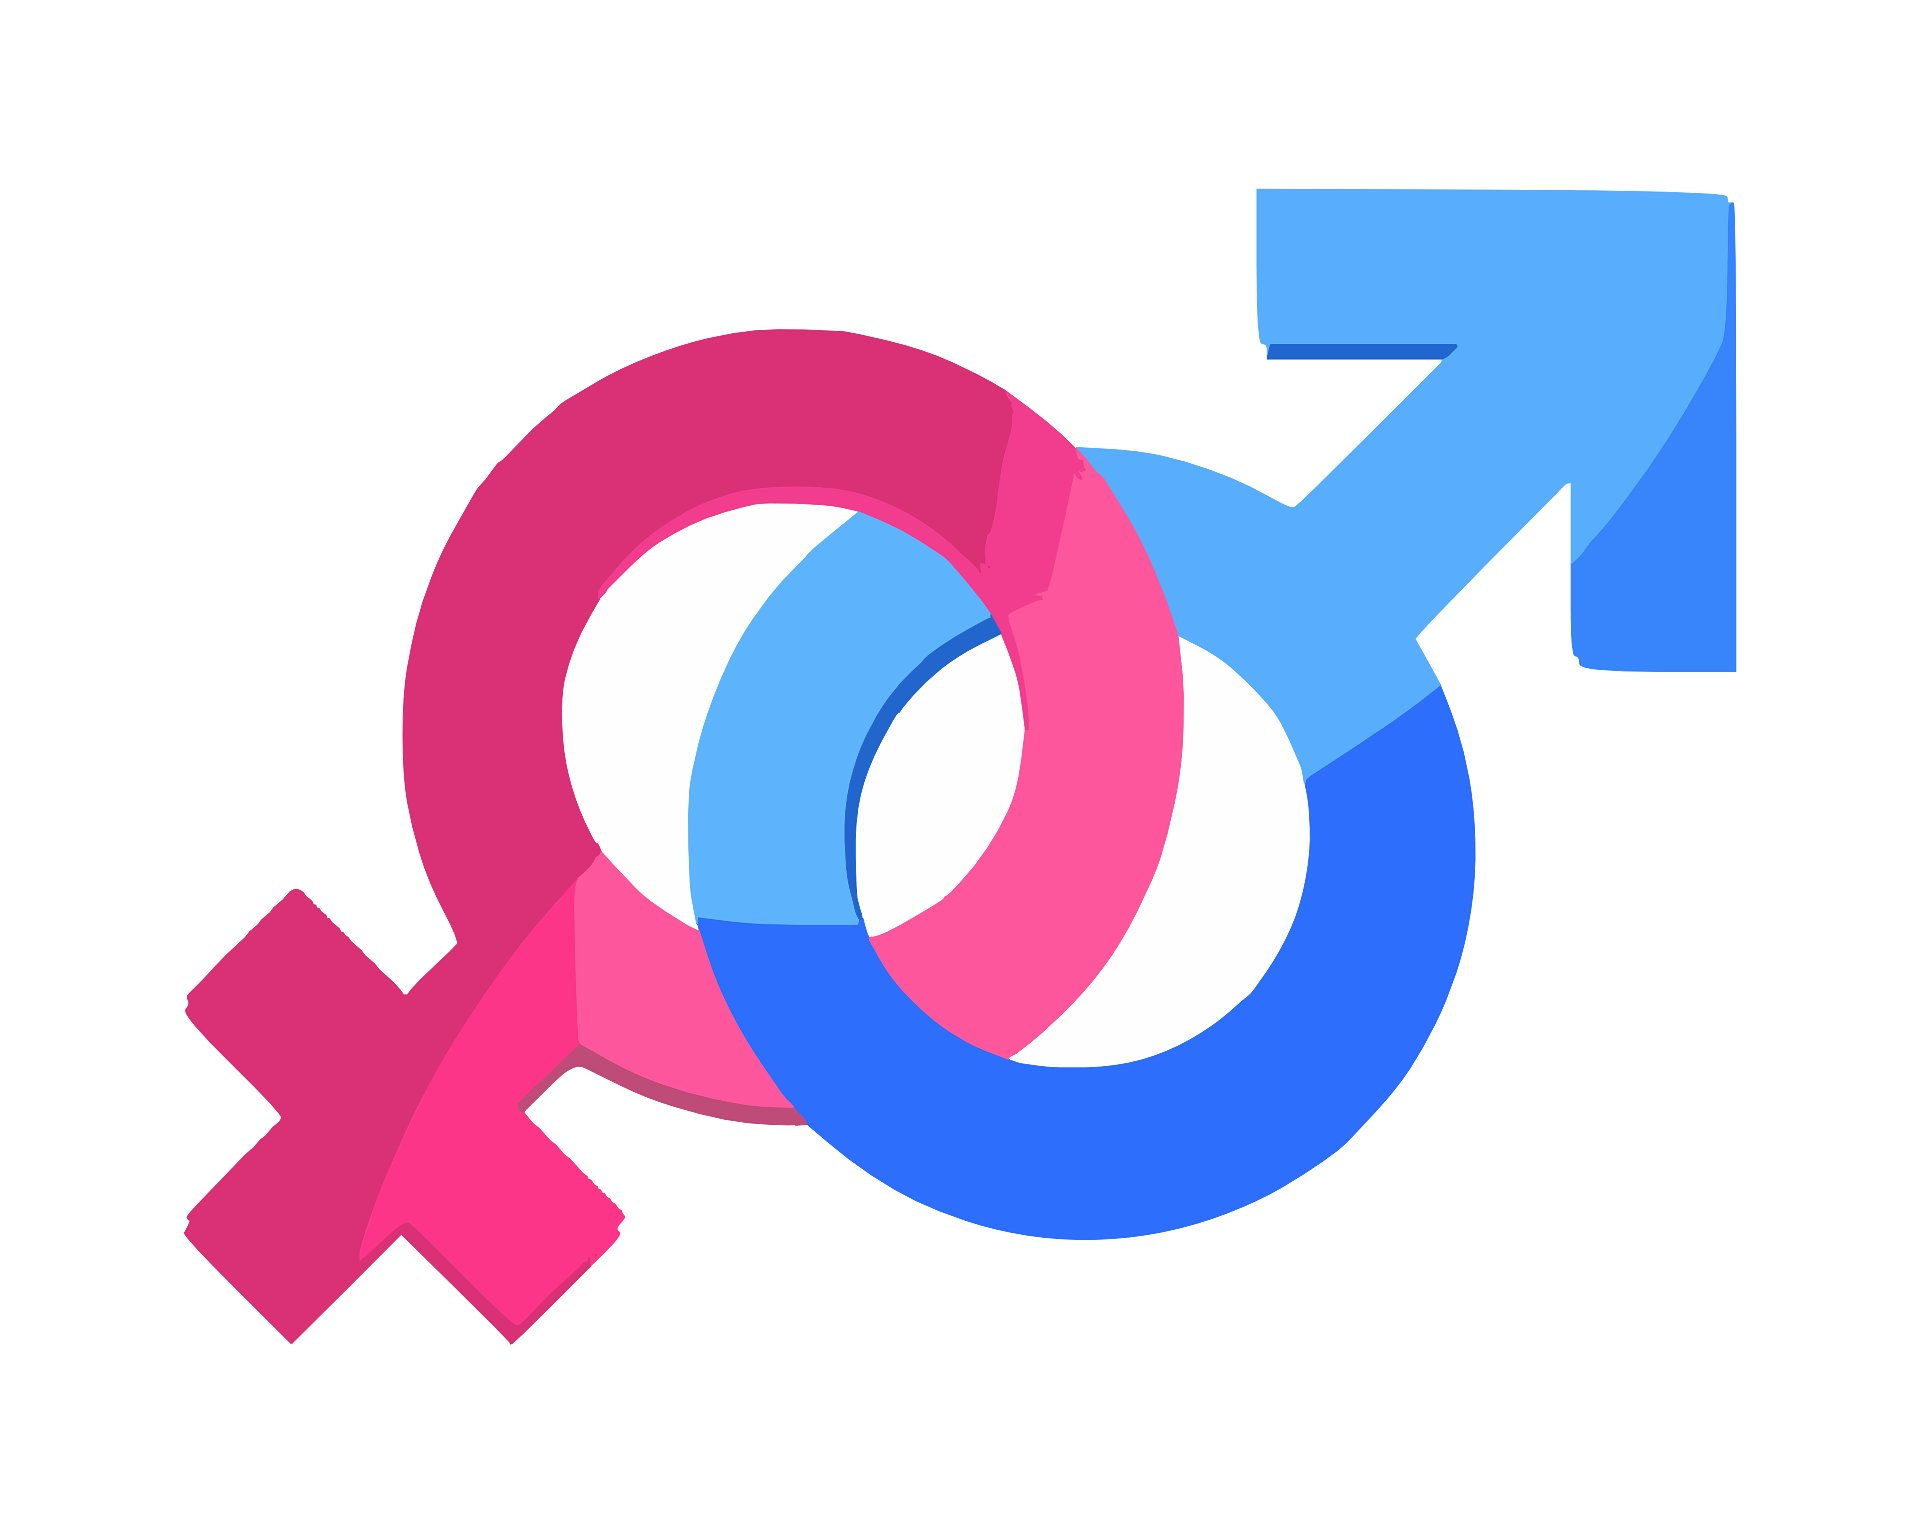

***
### Importing Dependencies

In [1]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import load_model, clone_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

from sklearn.metrics import f1_score, roc_curve, recall_score, roc_auc_score, precision_score, confusion_matrix, classification_report
from google.colab.files import download
from warnings import filterwarnings

import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import os

In [2]:
sns.set(style = 'darkgrid', palette = 'bright')
filterwarnings(action = 'ignore')

Let's create global path variables for train, validation and test sets.

In [3]:
TRAIN_DIR = '/content/drive/MyDrive/data/train'
VALID_DIR = '/content/drive/MyDrive/data/valid'
TEST_DIR = '/content/drive/MyDrive/data/test'

Let's create image generators for train, validation and test sets.

In [4]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range = 40, height_shift_range = 0.2, width_shift_range = 0.2, shear_range = 0.2, 
                                   zoom_range = 0.2, horizontal_flip = True)
valid_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

Let's load the image data from train, validation and test directories.

In [5]:
train_set = train_datagen.flow_from_directory(directory = TRAIN_DIR, target_size = (224, 224), class_mode = 'binary')
valid_set = valid_datagen.flow_from_directory(directory = VALID_DIR, target_size = (224, 224), class_mode = 'binary')
test_set = test_datagen.flow_from_directory(directory = TEST_DIR, target_size = (224, 224), class_mode = 'binary', shuffle = False)

Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Let's define the ground truth labels for test set, reverse label dictionary and define the number of classes.

In [6]:
NUM_CLASSES = train_set.num_classes - 1
y_test = test_set.labels.astype(dtype = np.float32)
LABEL_DICTIONARY = dict([(value, key) for key, value in train_set.class_indices.items()])

Let's define a function that will create a list of callbacks

In [7]:
def model_callbacks(model_path, monitoring_metric = 'val_loss', tolerance = 5, verbosity = 1):
  """
  This is a function that will create a list of callbacks, namely an early
  stopping and a model checkpoint callback to prevent a potential overfitting.

  Args:
    model_path: A path to a model instance.
    monitoring_metric: A metric to monitor during training.
    tolerance: A level of tolerance in case model does not improve.
    verbosity: A level of verbosity to display an output.

  Returns:
    A list of callbacks.
  """
  stop = EarlyStopping(monitor = monitoring_metric, patience = tolerance, restore_best_weights = True, verbose = verbosity)
  save = ModelCheckpoint(filepath = model_path, monitor = monitoring_metric, save_best_only = True, verbose = verbosity)
  callbacks = [stop, save]
  return callbacks

***
### Modelling: CNN model with Sequential API

In [8]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a CNN model with Sequential API
model_1 = Sequential(layers = [
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu'),
                     MaxPool2D(padding = 'same'),
                     Flatten(),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = 128, activation = 'relu'),
                     Dropout(rate = 0.5, seed = 42),
                     Dense(units = NUM_CLASSES, activation = 'sigmoid')
], name = 'Sequential_CNN')

# Compiling the model
model_1.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_1 = model_1.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_1.name}.h5'),
                               verbose = 1)

Epoch 1/100
110/110 [==============================] - 1681s 15s/step - loss: 0.6947 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69315, saving model to Sequential_CNN.h5
Epoch 2/100
110/110 [==============================] - 50s 456ms/step - loss: 0.6935 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.69315
Epoch 3/100
110/110 [==============================] - 50s 452ms/step - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.69315
Epoch 4/100
110/110 [==============================] - 50s 452ms/step - loss: 0.6938 - accuracy: 0.4973 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.69315
Epoch 5/100
110/110 [==============================] - 50s 455ms/step - loss: 0.6942 - accuracy: 0.4815 - val_loss: 0.6931 - val_accuracy: 0.5000

Epoch 00005: val_loss did 

In [9]:
# Displaying the summary of the model
model_1.summary()

Model: "Sequential_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)     

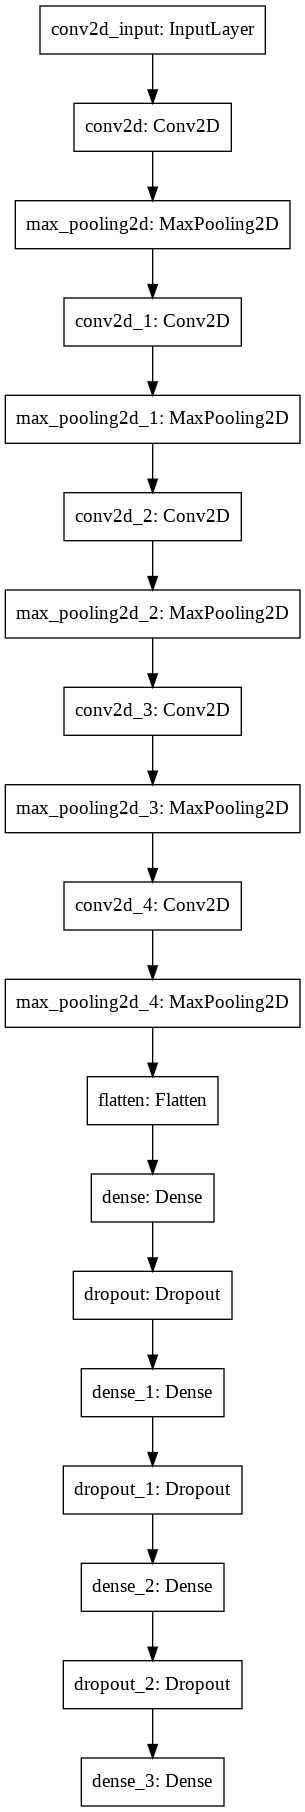

In [10]:
# Displaying the architecture of the model
plot_model(model = model_1, to_file = f'{model_1.name}.png')

Let's define a function that will visualize the model performance per epoch.

In [11]:
def visualize_model_performance(history, model_name):
  """
  This is a function that will visualize the performance of a particular model
  per epoch.

  Args:
    history: A model training history object.
    model_name: A name of a model.

  Returns:
    A two-dimensional plots for accuracy and loss curves.
  """
  valid_accuracy = history.history['val_accuracy']
  train_accuracy = history.history['accuracy']

  valid_loss = history.history['val_loss']
  train_loss = history.history['loss']

  plt.figure(figsize = (12, 8))
  plt.plot(train_accuracy, label = 'Train Accuracy', marker = 'o', c = 'teal')
  plt.plot(valid_accuracy, label = 'Valid Accuracy', marker = 'o', c = 'darkorange')
  plt.title(label = f'Accuracy Curve for {model_name} Model', fontsize = 16)
  plt.ylabel(ylabel = 'Accuracy', fontsize = 16)
  plt.xlabel(xlabel = 'Epochs', fontsize = 16)
  plt.legend(loc = 'lower right', fontsize = 16)
  plt.ylim([0.0, 1.05])
  plt.show()

  print()

  plt.figure(figsize = (12, 8))
  plt.plot(train_loss, label = 'Train Loss', marker = 'o', c = 'teal')
  plt.plot(valid_loss, label = 'Valid Loss', marker = 'o', c = 'darkorange')
  plt.title(label = f'Loss Curve for {model_name} Model', fontsize = 16)
  plt.xlabel(xlabel = 'Epochs', fontsize = 16)
  plt.ylabel(ylabel = 'Loss', fontsize = 16)
  plt.legend(loc = 'best', fontsize = 16)
  plt.show()

Let's call the function and visualize the performance of the model per epoch.

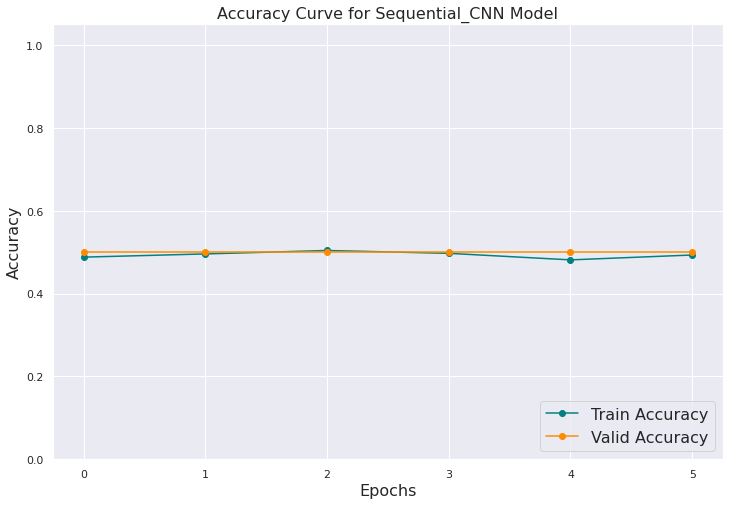

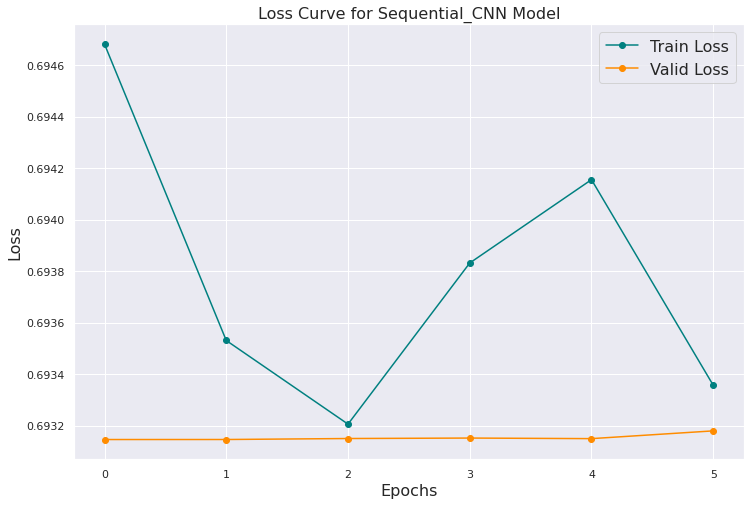

In [12]:
visualize_model_performance(history = model_training_1, model_name = model_1.name)

Let's define a function to print out a classification report for a particular model.

In [13]:
def print_model_report(y_true, y_pred, model_name = None):
  """
  This is a function that will print out a classification report for a 
  particular model.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    model_name: A name of a model

  Returns:
    Prints out the model report.
  """
  print(f'Classification report for {model_name} Model:\n')
  print(classification_report(y_true = y_true, y_pred = y_pred, target_names = ['Female', 'Male']))

Let's load the best model, make predictions on test set, call the function and print out the model report.

In [14]:
model_1 = load_model(filepath = f'{model_1.name}.h5')
model_1_predictions = tf.math.round(x = tf.squeeze(input = model_1.predict(x = test_set))).numpy()
print_model_report(y_true = y_test, y_pred = model_1_predictions, model_name = model_1.name)

Classification report for Sequential_CNN Model:

              precision    recall  f1-score   support

      Female       0.50      1.00      0.67       100
        Male       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



Let's define a function to plot confusion matrix.

In [15]:
def plot_confusion_matrix(y_true, y_pred, model_name = None):
  """
  This is a function that will plot a confusion matrix for a particular model.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    model_name: A name of a model.
  
  Returns:
    A two-dimensional plot.
  """
  labels = ['Female', 'Male']
  cm = confusion_matrix(y_true = y_true, y_pred = y_pred)
  upper_stack = cm[0] / np.sum(a = cm, axis = 1)[0]
  lower_stack = cm[1] / np.sum(a = cm, axis = 1)[1]
  final_stack = np.vstack(tup = (upper_stack, lower_stack))

  plt.figure(figsize = (12, 8))
  sns.heatmap(data = final_stack, yticklabels = labels, xticklabels = labels, annot = True, cbar = False, fmt = '.2%', cmap = plt.cm.Blues)
  plt.title(label = f'Confusion Matrix for {model_name} Model', fontsize = 16)
  plt.ylabel(ylabel = 'Ground Truth Labels', fontsize = 16)
  plt.xlabel(xlabel = 'Predicted Labels', fontsize = 16)
  plt.yticks(fontsize = 14)
  plt.xticks(fontsize = 14)
  plt.show()

Let's call the function and plot the confusion matrix.

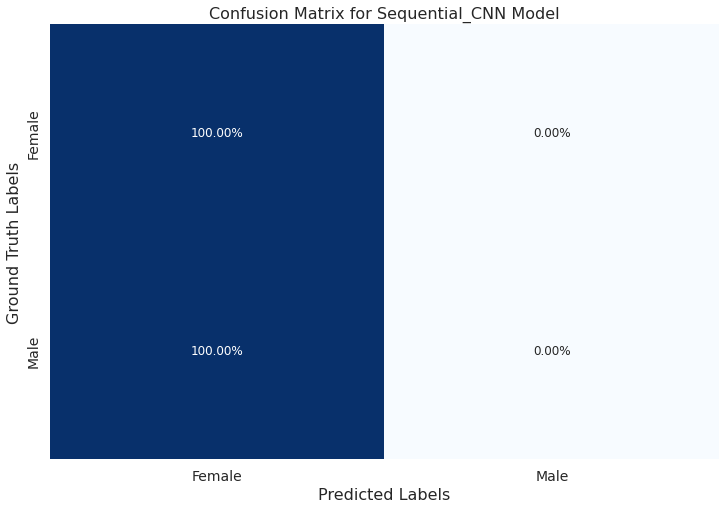

In [16]:
plot_confusion_matrix(y_true = y_test, y_pred = model_1_predictions, model_name = model_1.name)

Let's define a function to plot **Receiver Operating Characteristics (ROC)** curve.

In [17]:
def plot_roc_curve(y_true, y_pred, custom_objects = None, model_path = None):
  """
  This is a function that will plot a Receiver Operating Characteristics (ROC) 
  curve for a particular model.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    custom_objects: A dictionary object to pass an unknown layer.
    model_path: A path to a model instance.

  Returns:
    A two-dimensional plot.
  """
  model = load_model(filepath = model_path, custom_objects = custom_objects)
  model_name = model.name
  auc_score = roc_auc_score(y_true = y_true, y_score = y_pred)

  fpr, tpr, thresholds = roc_curve(y_true = y_true, y_score = tf.squeeze(input = model.predict(x = test_set)).numpy())

  plt.figure(figsize = (12, 8))
  plt.plot(fpr, tpr, label = f'{model_name} Model AUC Score: {auc_score:.2f}', c = 'teal')
  plt.plot([0, 1], [0, 1], label = 'Random Model', c = 'darkorange')
  plt.title(label = f'ROC Curve for {model_name} Model', fontsize = 16)
  plt.ylabel(ylabel = 'True Positive Rate (Recall)', fontsize = 16)
  plt.xlabel(xlabel = 'False Positive Rate', fontsize = 16)
  plt.legend(loc = 'lower right', fontsize = 16)
  plt.xlim([-0.02, 1.0])
  plt.ylim([0.0, 1.05])
  plt.show()

Let's call the function and plot ROC curve for the model.

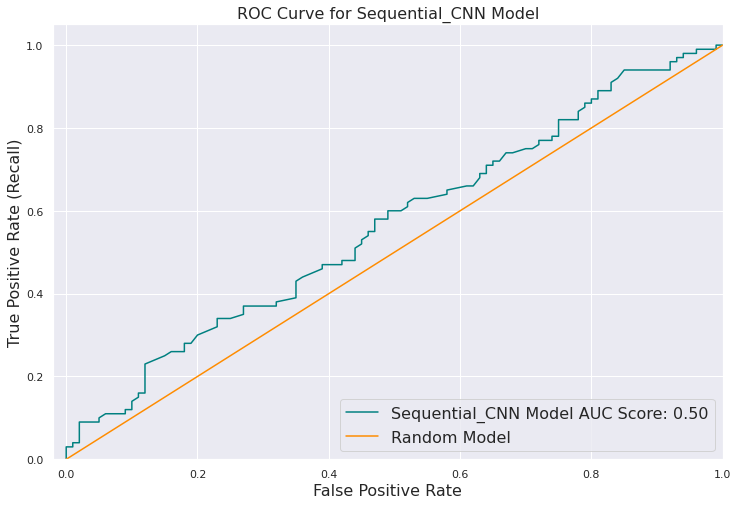

In [18]:
plot_roc_curve(y_true = y_test, y_pred = model_1_predictions, model_path = f'{model_1.name}.h5')

Let's define a function to randomly make predictions on test set.

In [19]:
def make_random_predictions(class_name, custom_objects = None, model_path = None, vgg_model = True):
  """
  This is a function that will make predictions on randomly selected images
  from test set.

  Args:
    class_name: A class label to make predictions on randomly selected images.
    custom_objects: A dictionary object to pass an unknown layer.
    model_path: A path to a model instance.
    vgg_model: Whether or not it is a vgg model.

  Returns:
    Two-dimensional images with ground truth, predicted labels and confidence.
  """
  model = load_model(filepath = model_path, custom_objects = custom_objects)

  random_images = random.choices(population = os.listdir(path = f'{TEST_DIR}/{class_name}'), k = 5)

  for random_image in random_images:
    filepath = f'{TEST_DIR}/{class_name}/{random_image}'
    loading_image = load_img(path = filepath, target_size = (224, 224))
    convertin_into_array = img_to_array(img = loading_image)
    expanding_dimensions = np.expand_dims(a = convertin_into_array, axis = 0)

    if vgg_model:
      preprocessed_image = preprocess_input(x = expanding_dimensions)
    else:
      preprocessed_image = expanding_dimensions / 255.0

    actual_class = class_name.capitalize()
    predicted_label = tf.cast(x = tf.math.round(x = tf.squeeze(input = model.predict(x = preprocessed_image))), dtype = tf.int32).numpy()
    predicted_proba = tf.squeeze(input = model.predict(x = preprocessed_image)).numpy()
    predicted_class = LABEL_DICTIONARY[predicted_label].capitalize()

    if predicted_label == 1:
      if predicted_class == actual_class:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {predicted_proba:.2%}', c = 'green')
        plt.axis('off')
        plt.show()
        print()
      else:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {predicted_proba:.2%}', c = 'red')
        plt.axis('off')
        plt.show()
        print()
    else:
      if predicted_class == actual_class:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'green')
        plt.axis('off')
        plt.show()
        print()
      else:
        plt.imshow(X = loading_image)
        plt.title(label = f'Actual --> {actual_class}\nPredicted --> {predicted_class}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'red')
        plt.axis('off')
        plt.show()
        print()

Let's call the function and make predictions on randomly selected female images.

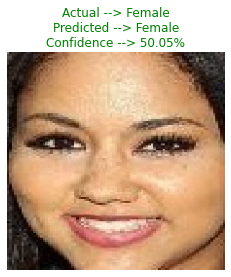

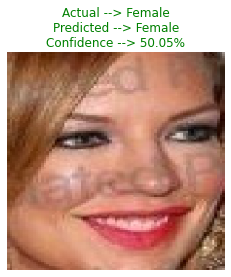

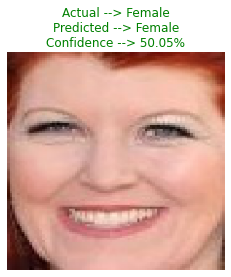

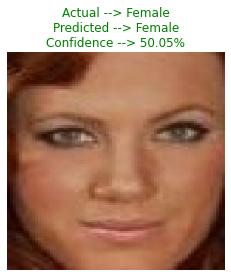

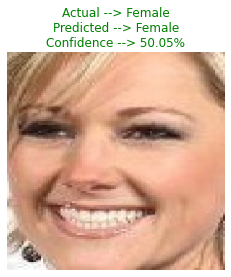

In [20]:
make_random_predictions(class_name = 'female', model_path = f'{model_1.name}.h5', vgg_model = False)

Let's call the function and make predictions on randomly selected male images.

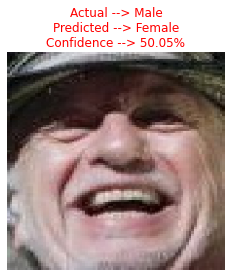

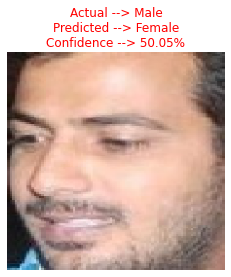

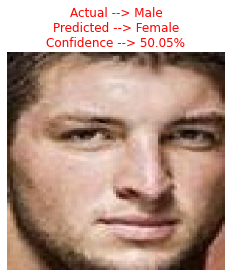

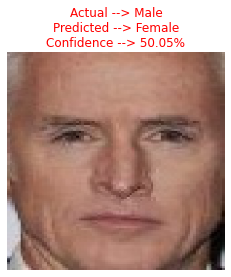

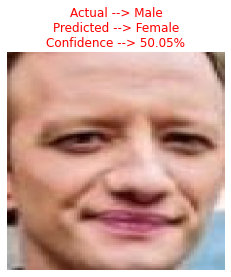

In [21]:
make_random_predictions(class_name = 'male', model_path = f'{model_1.name}.h5', vgg_model = False)

Let's define a function to evaluate the performance of the model using various evaluation metrics for a classification problem such as **Accuracy, F1 Score, Precision Score, Recall Score** and **AUC Score**.

In [22]:
def evaluate_model_performance(y_true, y_pred, custom_objects = None, model_path = None):
  """
  This is a function that will evaluate the performance of a particular model
  on a test set using various evaluation metrics for a classification problem
  such as Accuracy, F1 Score, Precision Score, Recall Score and AUC Score.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.
    custom_objects: A dictionary object to pass an unknown layer.
    model_path: A path to a model instance.

  Returns:
    A pandas dataframe.
  """
  model = load_model(filepath = model_path, custom_objects = custom_objects)
  model_name = model.name

  _, train_accuracy = model.evaluate(train_set, verbose = 0)
  _, valid_accuracy = model.evaluate(valid_set, verbose = 0)
  _, test_accuracy = model.evaluate(test_set, verbose = 0)

  PRECISION_SCORE = precision_score(y_true = y_true, y_pred = y_pred)
  RECALL_SCORE = recall_score(y_true = y_true, y_pred = y_pred)
  AUC_SCORE = roc_auc_score(y_true = y_true, y_score = y_pred)
  F1_SCORE = f1_score(y_true = y_true, y_pred = y_pred)

  COLUMNS = ['Train_Accuracy', 'Validation_Accuracy', 'Test_Accuracy',
             'Precision_Score', 'Recall_Score', 'AUC_Score', 'F1_Score']

  df = pd.DataFrame(columns = COLUMNS, index = [model_name + ' Model'])
  df['Train_Accuracy'] = round(number = train_accuracy, ndigits = 2)
  df['Validation_Accuracy'] = round(number = valid_accuracy, ndigits = 2)
  df['Test_Accuracy'] = round(number = test_accuracy, ndigits = 2)
  df['Precision_Score'] = round(number = PRECISION_SCORE, ndigits = 2)
  df['Recall_Score'] = round(number = RECALL_SCORE, ndigits = 2)
  df['AUC_Score'] = round(number = AUC_SCORE, ndigits = 2)
  df['F1_Score'] = round(number = F1_SCORE, ndigits = 2)

  return df

Let's call the function and evaluate the performance of the model.

In [23]:
model_1_df = evaluate_model_performance(y_true = y_test, y_pred = model_1_predictions, model_path = f'{model_1.name}.h5')
model_1_df

Train_Accuracy  Validation_Accuracy  ...  AUC_Score  F1_Score
Sequential_CNN Model             0.5                  0.5  ...        0.5       0.0

[1 rows x 7 columns]

Let's build the same CNN model with **Functional API**.

In [24]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a CNN model with Functional API
input_layer = Input(shape = (224, 224, 3), name = 'Input_Layer')
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(input_layer)
x = MaxPool2D(padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPool2D(padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPool2D(padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPool2D(padding = 'same')(x)
x = Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same', activation = 'relu')(x)
x = MaxPool2D(padding = 'same')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
x = Dense(units = 128, activation = 'relu')(x)
x = Dropout(rate = 0.5, seed = 42)(x)
output_layer = Dense(units = NUM_CLASSES, activation = 'sigmoid', name = 'Output_Layer')(x)
model_2 = Model(inputs = input_layer, outputs = output_layer, name = 'Functional_CNN')

# Compiling the model
model_2.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_2 = model_2.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_2.name}.h5'),
                               verbose = 1)

Epoch 1/100
110/110 [==============================] - 52s 462ms/step - loss: 0.6944 - accuracy: 0.4884 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.69318, saving model to Functional_CNN.h5
Epoch 2/100
110/110 [==============================] - 51s 459ms/step - loss: 0.6936 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.69318
Epoch 3/100
110/110 [==============================] - 50s 457ms/step - loss: 0.6962 - accuracy: 0.4835 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00003: val_loss improved from 0.69318 to 0.69316, saving model to Functional_CNN.h5
Epoch 4/100
110/110 [==============================] - 51s 465ms/step - loss: 0.6936 - accuracy: 0.4898 - val_loss: 0.6932 - val_accuracy: 0.5000

Epoch 00004: val_loss did not improve from 0.69316
Epoch 5/100
110/110 [==============================] - 51s 466ms/step - loss: 0.6936 - accuracy: 0.5001 - val_loss: 0.6935 - val_accur

In [25]:
# Displaying the summary of the model
model_2.summary()

Model: "Functional_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 28, 28, 64)     

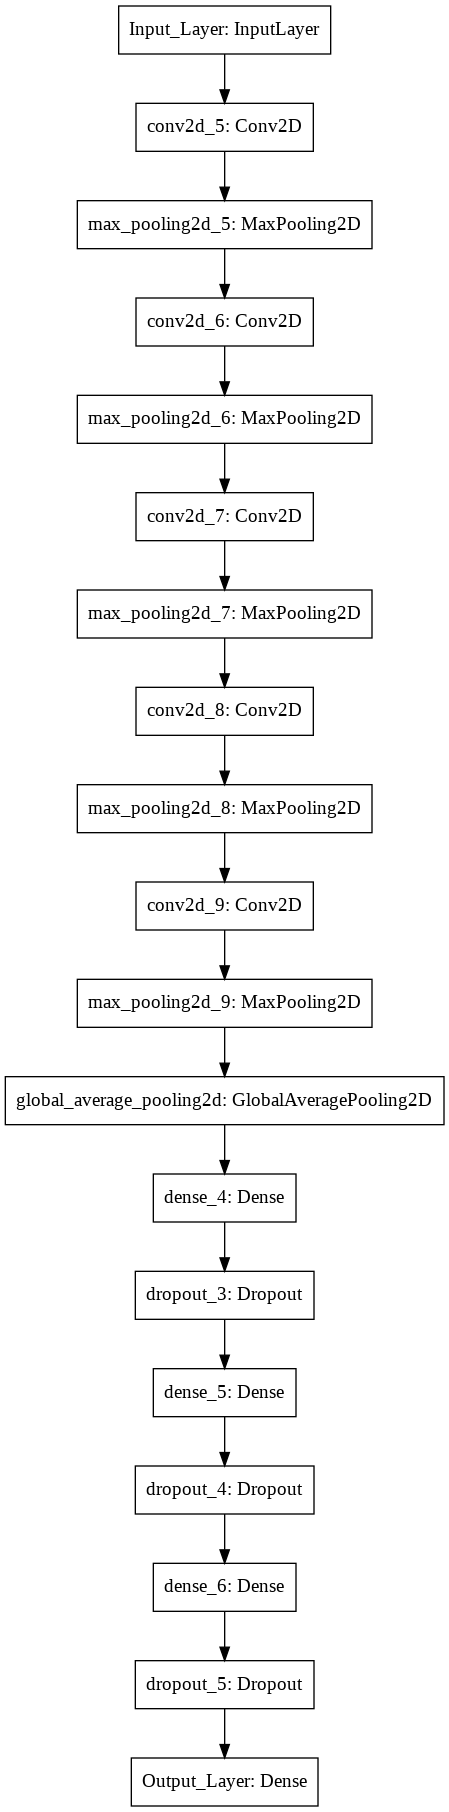

In [26]:
# Displaying the architecture of the model
plot_model(model = model_2, to_file = f'{model_2.name}.png')

Let's call the function and visualize the performance of the model per epoch.

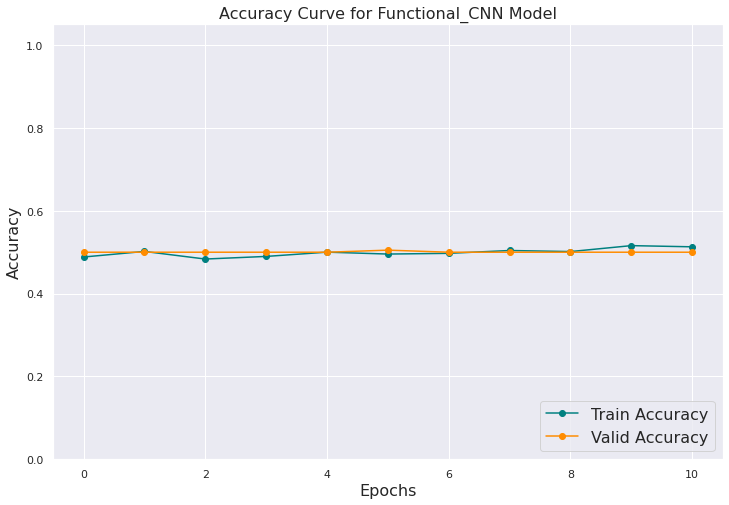

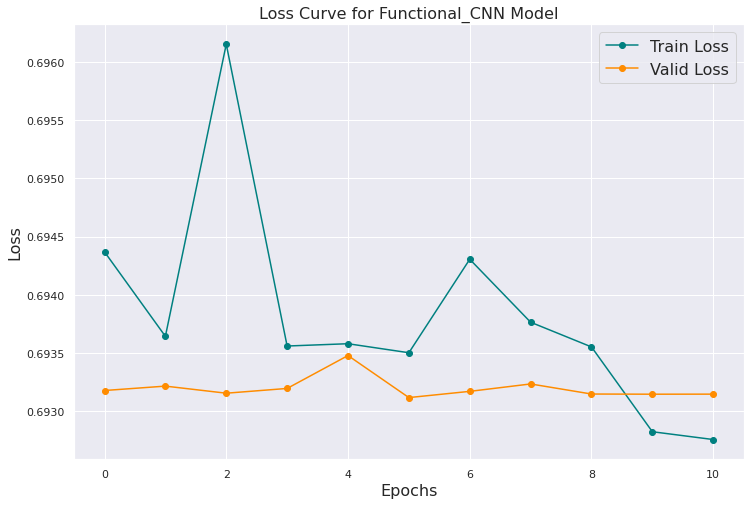

In [27]:
visualize_model_performance(history = model_training_2, model_name = model_2.name)

Let's load the best model, make predictions on test set, call the function and print out the model report.

In [28]:
model_2 = load_model(filepath = f'{model_2.name}.h5')
model_2_predictions = tf.math.round(x = tf.squeeze(input = model_2.predict(x = test_set))).numpy()
print_model_report(y_true = y_test, y_pred = model_2_predictions, model_name = model_2.name)

Classification report for Functional_CNN Model:

              precision    recall  f1-score   support

      Female       0.50      1.00      0.67       100
        Male       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



Let's call the function and plot the confusion matrix.

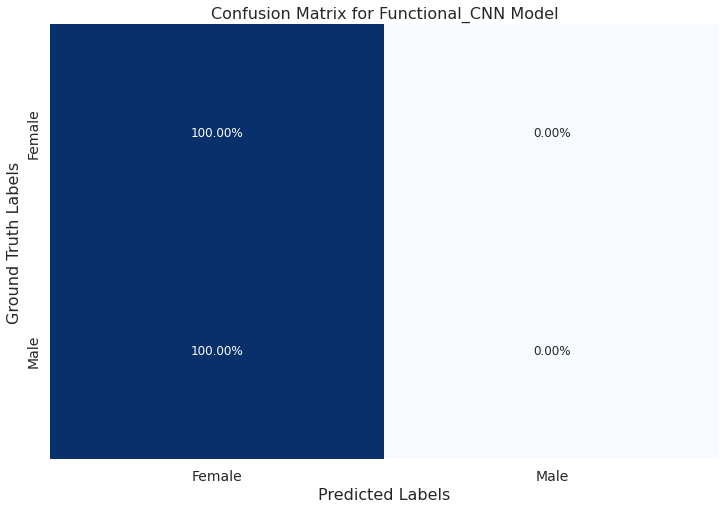

In [29]:
plot_confusion_matrix(y_true = y_test, y_pred = model_2_predictions, model_name = model_2.name)

Let's call the function and plot ROC curve for the model.

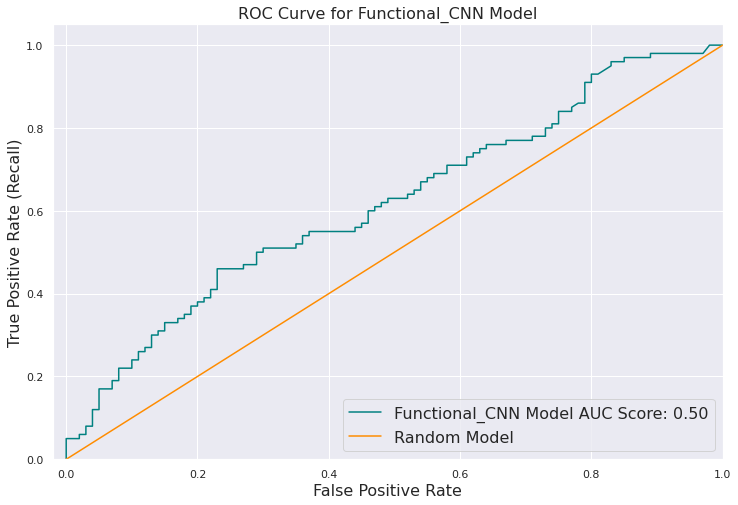

In [30]:
plot_roc_curve(y_true = y_test, y_pred = model_2_predictions, model_path = f'{model_2.name}.h5')

Let's call the function and make predictions on randomly selected female images.

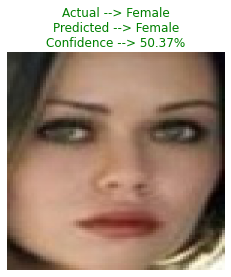

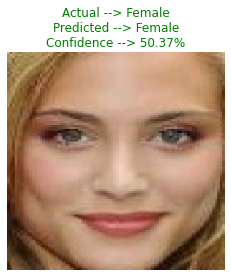

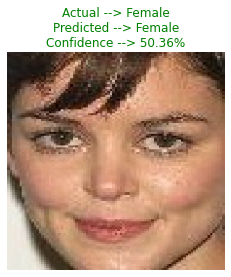

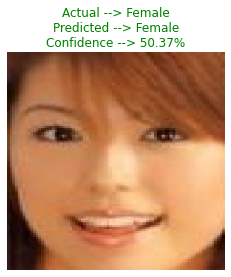

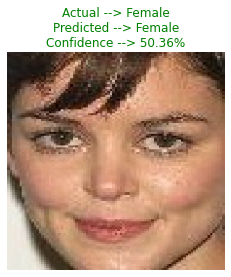

In [31]:
make_random_predictions(class_name = 'female', model_path = f'{model_2.name}.h5', vgg_model = False)

Let's call the function and make predictions on randomly selected female images.

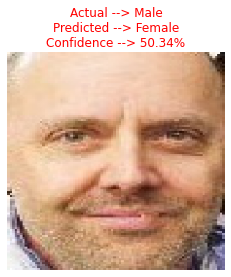

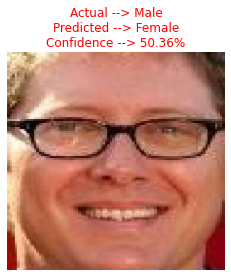

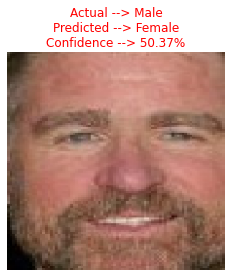

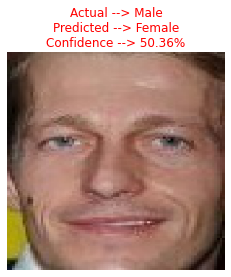

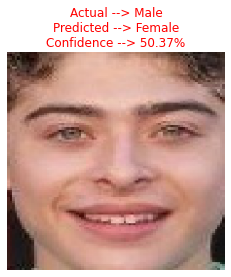

In [32]:
make_random_predictions(class_name = 'male', model_path = f'{model_2.name}.h5', vgg_model = False)

Let's call the function and evaluate the performance of the model.

In [33]:
model_2_df = evaluate_model_performance(y_true = y_test, y_pred = model_2_predictions, model_path = f'{model_2.name}.h5')
model_2_df

Train_Accuracy  Validation_Accuracy  ...  AUC_Score  F1_Score
Functional_CNN Model            0.51                  0.5  ...        0.5       0.0

[1 rows x 7 columns]

Let's download and **Resnet50 Feature Vector**.

In [34]:
resnet_50 = hub.KerasLayer(handle = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1', trainable = False)

Let's build a Feature extraction model with **Functional API**.

In [35]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Resnet50 feature extraction model with Functional API
input_layer = Input(shape = (224, 224, 3), name = 'Input_Layer')
x = resnet_50(input_layer)
output_layer = Dense(units = NUM_CLASSES, activation = 'sigmoid', name = 'Output_Layer')(x)
model_3 = Model(inputs = input_layer, outputs = output_layer, name = 'Feature_Extraction_Resnet_50')

# Compiling the model
model_3.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_3 = model_3.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_3.name}.h5'),
                               verbose = 1)

Epoch 1/100
110/110 [==============================] - 65s 517ms/step - loss: 0.4329 - accuracy: 0.8032 - val_loss: 0.3215 - val_accuracy: 0.8650

Epoch 00001: val_loss improved from inf to 0.32148, saving model to Feature_Extraction_Resnet_50.h5
Epoch 2/100
110/110 [==============================] - 55s 501ms/step - loss: 0.3387 - accuracy: 0.8531 - val_loss: 0.2991 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.32148 to 0.29907, saving model to Feature_Extraction_Resnet_50.h5
Epoch 3/100
110/110 [==============================] - 55s 498ms/step - loss: 0.3075 - accuracy: 0.8731 - val_loss: 0.2959 - val_accuracy: 0.8850

Epoch 00003: val_loss improved from 0.29907 to 0.29593, saving model to Feature_Extraction_Resnet_50.h5
Epoch 4/100
110/110 [==============================] - 55s 499ms/step - loss: 0.3112 - accuracy: 0.8677 - val_loss: 0.2562 - val_accuracy: 0.8800

Epoch 00004: val_loss improved from 0.29593 to 0.25623, saving model to Feature_Extraction_Resnet_50.h5


In [36]:
# Displaying the summary of the model
model_3.summary()

Model: "Feature_Extraction_Resnet_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23561152  
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 2049      
Total params: 23,563,201
Trainable params: 2,049
Non-trainable params: 23,561,152
_________________________________________________________________


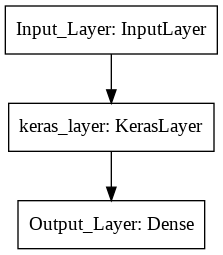

In [37]:
# Displaying the architecture of the model
plot_model(model = model_3, to_file = f'{model_3.name}.png')

Let's call the function and visualize the performance of the model per epoch.

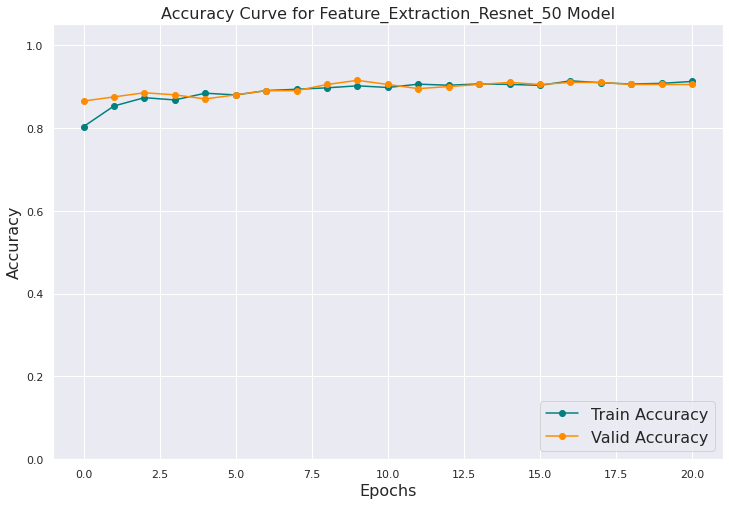

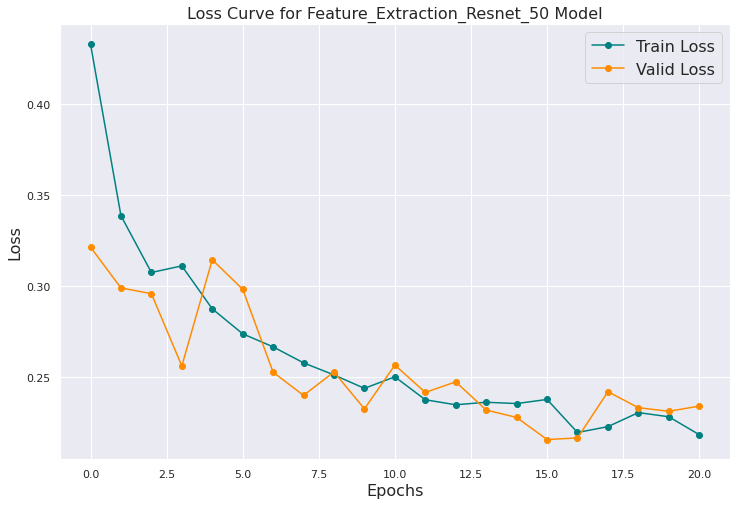

In [38]:
visualize_model_performance(history = model_training_3, model_name = model_3.name)

Let's define a dictionary to pass an unknown layer.

In [39]:
CUSTOM_OBJECTS = {'KerasLayer':hub.KerasLayer}

Let's load the best model, make predictions on test set, call the function and print out the model report.

In [40]:
model_3 = load_model(filepath = f'{model_3.name}.h5', custom_objects = CUSTOM_OBJECTS)
model_3_predictions = tf.math.round(x = tf.squeeze(input = model_3.predict(x = test_set))).numpy()
print_model_report(y_true = y_test, y_pred = model_3_predictions, model_name = model_3.name)

Classification report for Feature_Extraction_Resnet_50 Model:

              precision    recall  f1-score   support

      Female       0.96      0.97      0.97       100
        Male       0.97      0.96      0.96       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



Let's call the function and plot the confusion matrix.

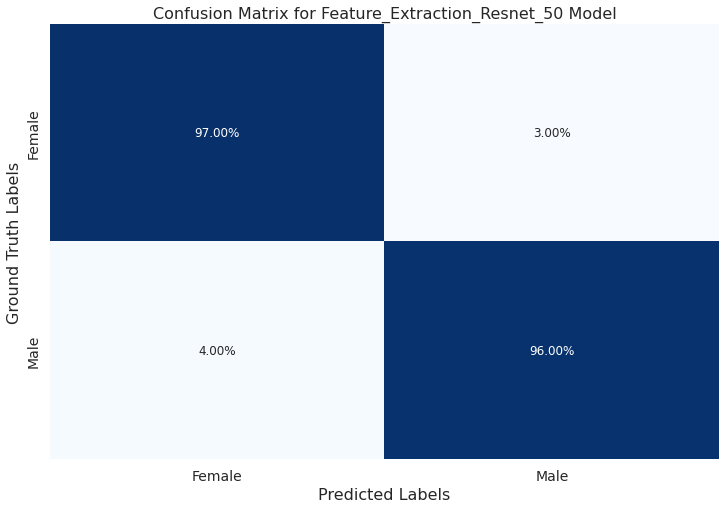

In [41]:
plot_confusion_matrix(y_true = y_test, y_pred = model_3_predictions, model_name = model_3.name)

Let's call the function and plot the ROC curve.

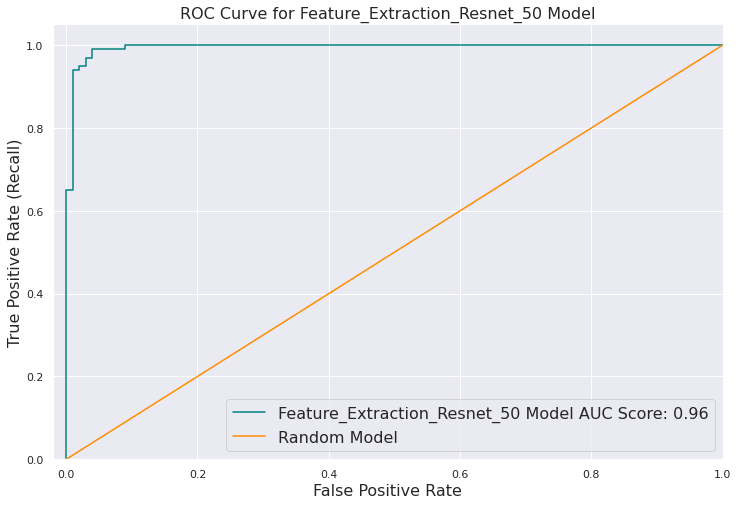

In [42]:
plot_roc_curve(y_true = y_test, y_pred = model_3_predictions, custom_objects = CUSTOM_OBJECTS, model_path = f'{model_3.name}.h5')

Let's call the function and make predictions on randomly selected female images.

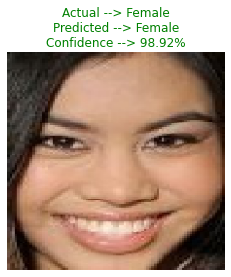

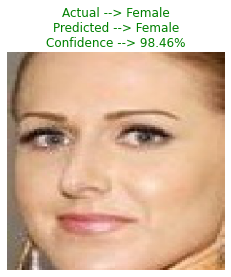

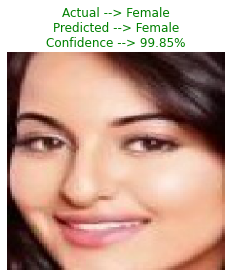

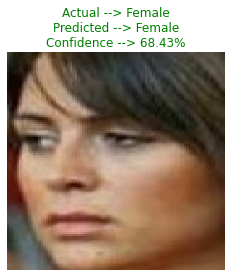

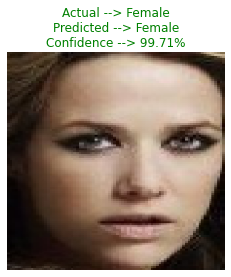

In [43]:
make_random_predictions(class_name = 'female', custom_objects = CUSTOM_OBJECTS, model_path = f'{model_3.name}.h5', vgg_model = False)

Let's call the function and make predictions on randomly selected male images.

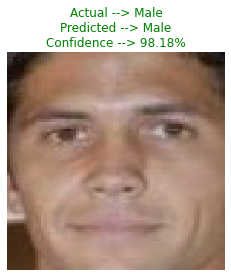

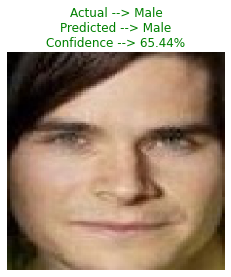

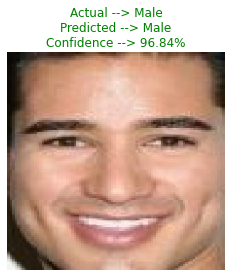

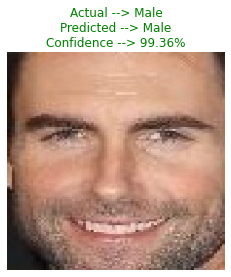

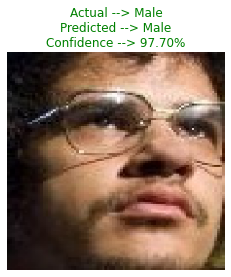

In [44]:
make_random_predictions(class_name = 'male', custom_objects = CUSTOM_OBJECTS, model_path = f'{model_3.name}.h5', vgg_model = False)

Let's call the function and evaluate the performance of the model.

In [45]:
model_3_df = evaluate_model_performance(y_true = y_test, y_pred = model_3_predictions, custom_objects = CUSTOM_OBJECTS, 
                                        model_path = f'{model_3.name}.h5')
model_3_df

Train_Accuracy  ...  F1_Score
Feature_Extraction_Resnet_50 Model            0.91  ...      0.96

[1 rows x 7 columns]

Let's create VGG19 image generators for train, validation and test set.

In [46]:
vgg_19_image_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

Let's create a train, validation and test sets.

In [47]:
train_set = vgg_19_image_datagen.flow_from_directory(directory = TRAIN_DIR, target_size = (224, 224), class_mode = 'binary')
valid_set = vgg_19_image_datagen.flow_from_directory(directory = VALID_DIR, target_size = (224, 224), class_mode = 'binary')
test_set = vgg_19_image_datagen.flow_from_directory(directory = TEST_DIR, target_size = (224, 224), class_mode = 'binary', shuffle = False)

Found 3491 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


Let's build VGG19 feature extraction model with **Functional API**.

In [48]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Instantiating a VGG19 model without fully connected layer
vgg_19 = VGG19(include_top = False)

# Freezing all the layers
vgg_19.trainable = False

# Creating VGG19 feature extraction model with Functional API
input_layer = Input(shape = (224, 224, 3), name = 'Input_Layer')
x = vgg_19(input_layer)
x = GlobalAveragePooling2D()(x)
output_layer = Dense(units = NUM_CLASSES, activation = 'sigmoid', name = 'Output_Layer')(x)
model_4 = Model(inputs = input_layer, outputs = output_layer, name = 'Feature_Extraction_VGG_19')

# Compiling the model
model_4.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_4 = model_4.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_4.name}.h5'),
                               verbose = 1)

80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/100
110/110 [==============================] - 50s 356ms/step - loss: 1.0009 - accuracy: 0.6500 - val_loss: 0.4579 - val_accuracy: 0.7950

Epoch 00001: val_loss improved from inf to 0.45793, saving model to Feature_Extraction_VGG_19.h5
Epoch 2/100
110/110 [==============================] - 34s 311ms/step - loss: 0.3810 - accuracy: 0.8370 - val_loss: 0.3704 - val_accuracy: 0.8200

Epoch 00002: val_loss improved from 0.45793 to 0.37038, saving model to Feature_Extraction_VGG_19.h5
Epoch 3/100
110/110 [==============================] - 34s 311ms/step - loss: 0.3152 - accuracy: 0.8700 - val_loss: 0.3275 - val_accuracy: 0.8300

Epoch 00003: val_loss improved from 0.37038 to 0.32754, saving model to Feature_Extraction_VGG_19.h5
Epoch 4/100
110/110 [==============================] - 34s 311ms/step - loss: 0.2800 - accuracy: 0.8880 - val_loss: 0.3046 - val_accuracy: 0.8550

Epoch 00004: val_loss improved from 0.32754 to 0

In [49]:
# Displaying the summary of the model
model_4.summary()

Model: "Feature_Extraction_VGG_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


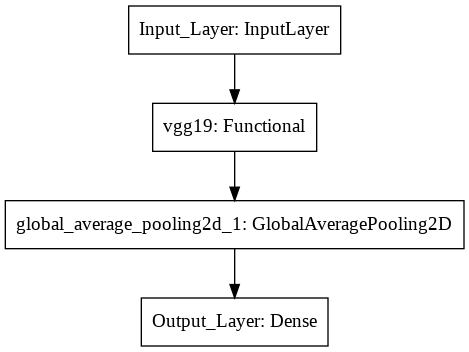

In [50]:
# Displaying the architecture of the model
plot_model(model = model_4, to_file = f'{model_4.name}.png')

Let's call the function and visualize the performance of the model per epoch.

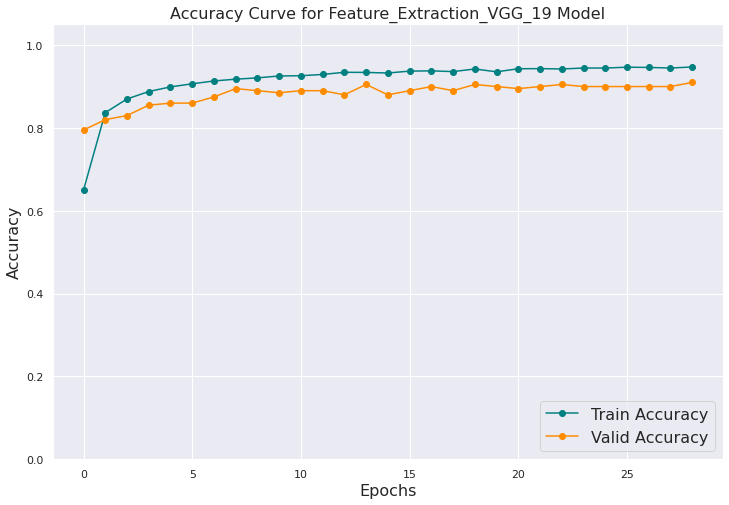

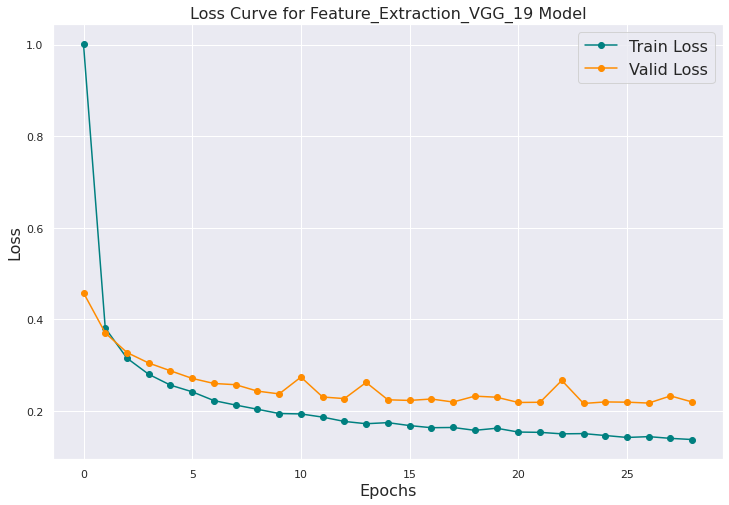

In [51]:
visualize_model_performance(history = model_training_4, model_name = model_4.name)

Let's load the best model, make predictions on test set, call the funciton and print out the model report.

In [52]:
model_4 = load_model(filepath = f'{model_4.name}.h5')
model_4_predictions = tf.math.round(x = tf.squeeze(input = model_4.predict(x = test_set))).numpy()
print_model_report(y_true = y_test, y_pred = model_4_predictions, model_name = model_4.name)

Classification report for Feature_Extraction_VGG_19 Model:

              precision    recall  f1-score   support

      Female       0.91      0.95      0.93       100
        Male       0.95      0.91      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



Let's call the function and plot confusion matrix.

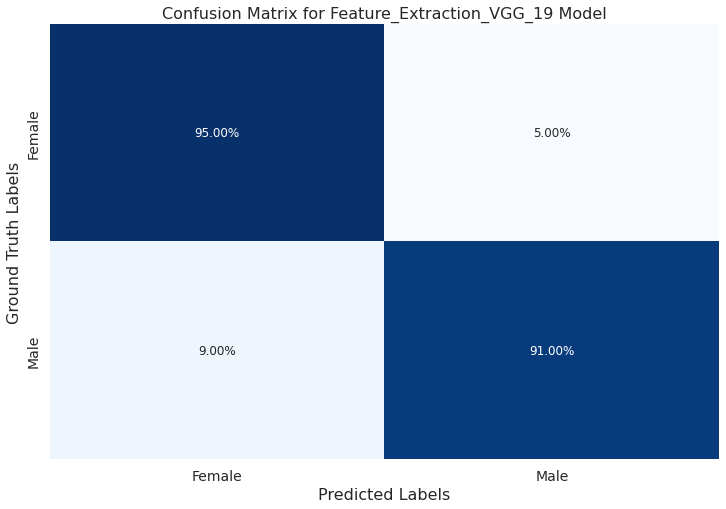

In [53]:
plot_confusion_matrix(y_true = y_test, y_pred = model_4_predictions, model_name = model_4.name)

Let's call the function and plot the ROC curve.

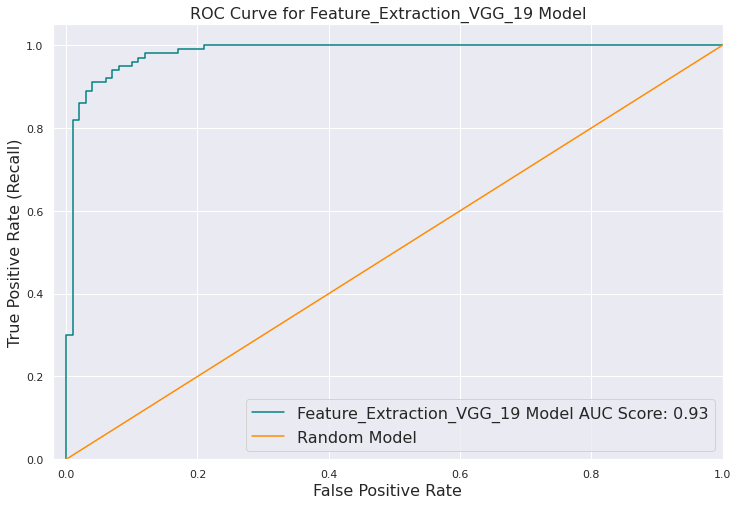

In [54]:
plot_roc_curve(y_true = y_test, y_pred = model_4_predictions, model_path = f'{model_4.name}.h5')

Let's call the function and make predictions on randomly selected female images.

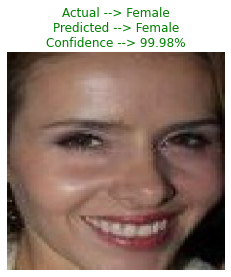

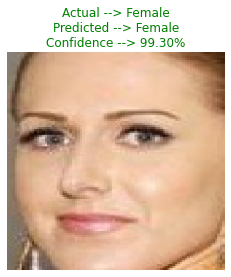

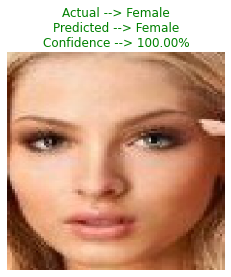

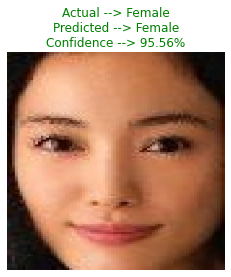

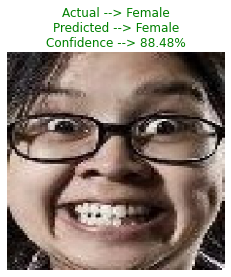

In [55]:
make_random_predictions(class_name = 'female', model_path = f'{model_4.name}.h5')

Let's call the function and make predictions on randomly selected male images.

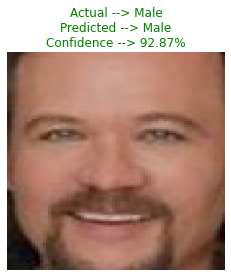

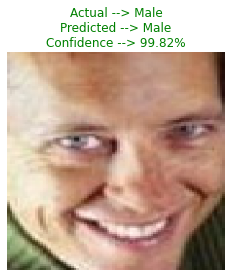

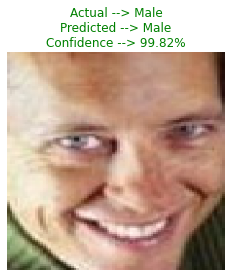

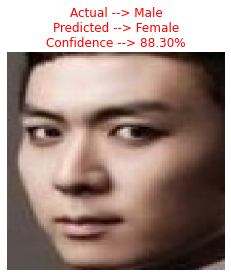

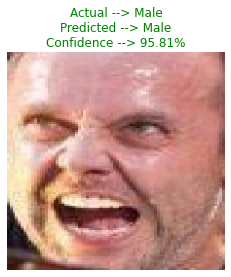

In [56]:
make_random_predictions(class_name = 'male', model_path = f'{model_4.name}.h5')

Let's call the function and evaluate the performance of the model.

In [57]:
model_4_df = evaluate_model_performance(y_true = y_test, y_pred = model_4_predictions, model_path = f'{model_4.name}.h5')
model_4_df

Train_Accuracy  ...  F1_Score
Feature_Extraction_VGG_19 Model            0.95  ...      0.93

[1 rows x 7 columns]

Let's create a Fine-Tuned VGG19 model with **Sequential API**.

In [58]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Instantiating VGG19 model with fully connected layer
vgg_19 = VGG19()

# Setting all the layers as trainable
vgg_19.trainable = True

# Creating a Fine-Tuned VGG19 model with Sequential API
model_5 = Sequential(name = 'Fine_Tuned_VGG_19')

# Adding all the layers except the output layer.
for layer in vgg_19.layers[:-1]:
  model_5.add(layer = layer)

# Freezing all the layers except the last two
for layer in model_5.layers[:-2]:
  layer.trainable = False

# Adding an output layer
model_5.add(layer = Dense(units = NUM_CLASSES, activation = 'sigmoid'))

# Compiling the model
model_5.compile(optimizer = Adam(), loss = BinaryCrossentropy(), metrics = ['accuracy'])

# Fitting the model
model_training_5 = model_5.fit(train_set, epochs = 100, validation_data = valid_set,
                               callbacks = model_callbacks(model_path = f'{model_5.name}.h5'),
                               verbose = 1)

574726144/574710816 [==============================] - 5s 0us/step
Epoch 1/100
110/110 [==============================] - 40s 355ms/step - loss: 2.2372 - accuracy: 0.8493 - val_loss: 0.2825 - val_accuracy: 0.9150

Epoch 00001: val_loss improved from inf to 0.28249, saving model to Fine_Tuned_VGG_19.h5
Epoch 2/100
110/110 [==============================] - 39s 353ms/step - loss: 0.1195 - accuracy: 0.9602 - val_loss: 0.3280 - val_accuracy: 0.8900

Epoch 00002: val_loss did not improve from 0.28249
Epoch 3/100
110/110 [==============================] - 39s 353ms/step - loss: 0.0719 - accuracy: 0.9779 - val_loss: 0.4804 - val_accuracy: 0.9100

Epoch 00003: val_loss did not improve from 0.28249
Epoch 4/100
110/110 [==============================] - 39s 353ms/step - loss: 0.0391 - accuracy: 0.9848 - val_loss: 0.9632 - val_accuracy: 0.8850

Epoch 00004: val_loss did not improve from 0.28249
Epoch 5/100
110/110 [==============================] - 39s 353ms/step - loss: 0.0317 - accuracy: 0.9908

In [59]:
# Displaying the summary of the model
model_5.summary()

Model: "Fine_Tuned_VGG_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256) 

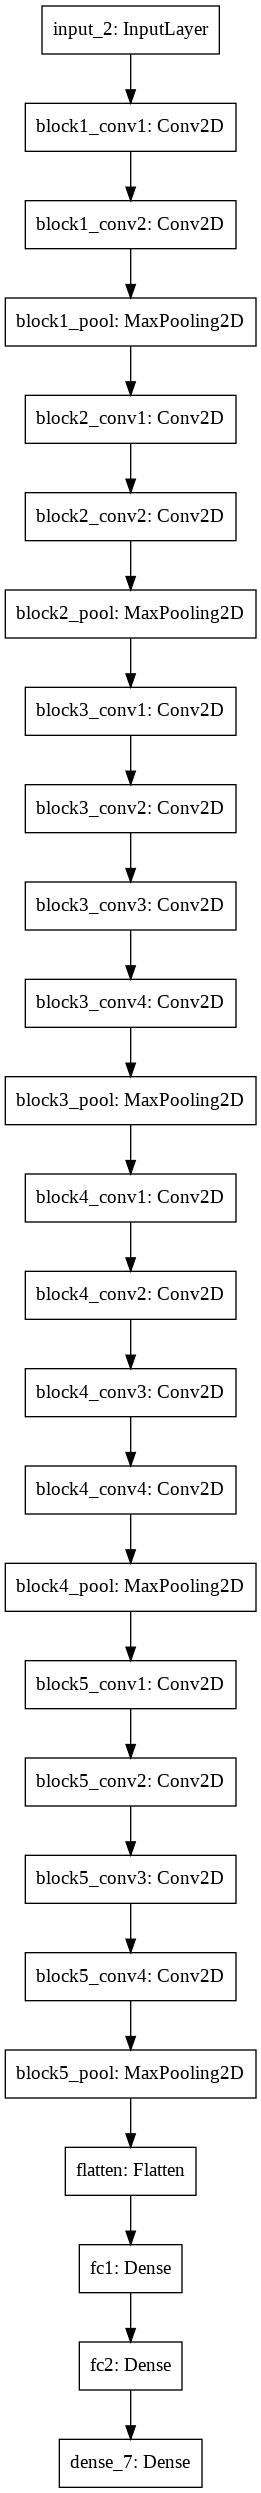

In [60]:
# Displaying the architecture of the model
plot_model(model = model_5, to_file = f'{model_5.name}.png')

Let's call the function and visualize the performance of the model per epoch.

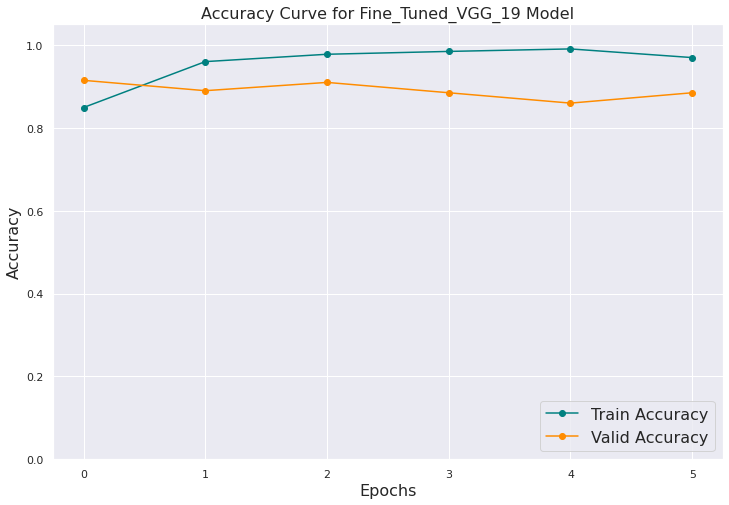

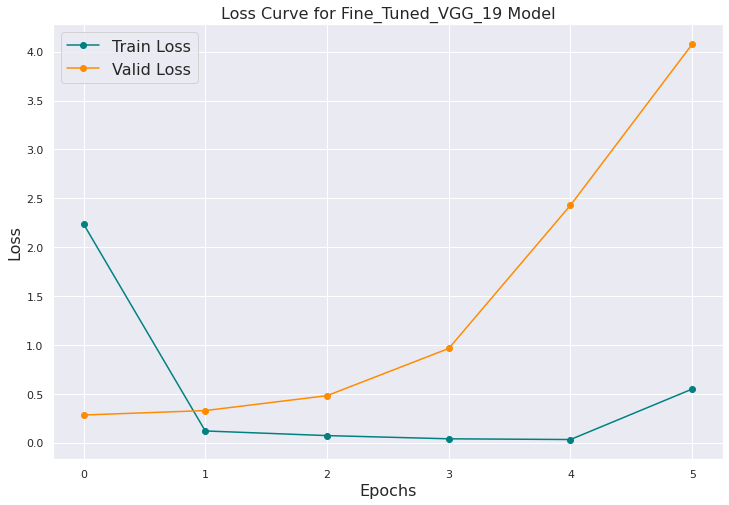

In [61]:
visualize_model_performance(history = model_training_5, model_name = model_5.name)

Let's load the best model, make predictions on test set, call the function and print the model report.

In [62]:
model_5 = load_model(filepath = f'{model_5.name}.h5')
model_5_predictions = tf.math.round(x = tf.squeeze(input = model_5.predict(x = test_set))).numpy()
print_model_report(y_true = y_test, y_pred = model_5_predictions, model_name = model_5.name)

Classification report for Fine_Tuned_VGG_19 Model:

              precision    recall  f1-score   support

      Female       0.91      1.00      0.95       100
        Male       1.00      0.90      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



Let's call the function and plot the confusion matrix.

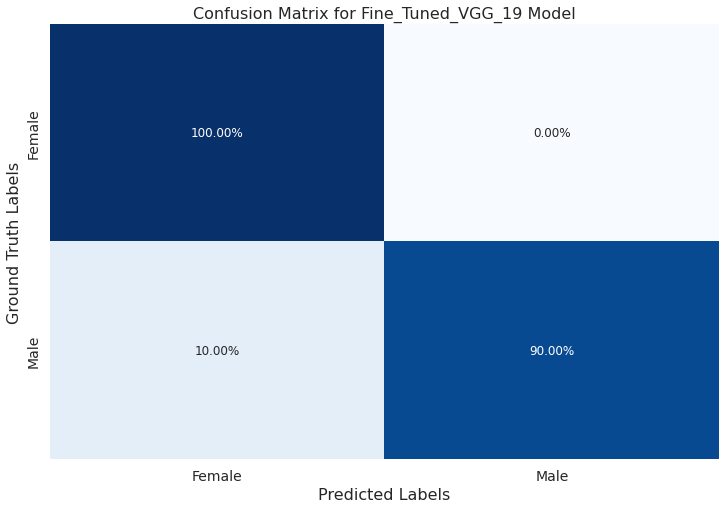

In [63]:
plot_confusion_matrix(y_true = y_test, y_pred = model_5_predictions, model_name = model_5.name)

Let's call the function and plot ROC curve.

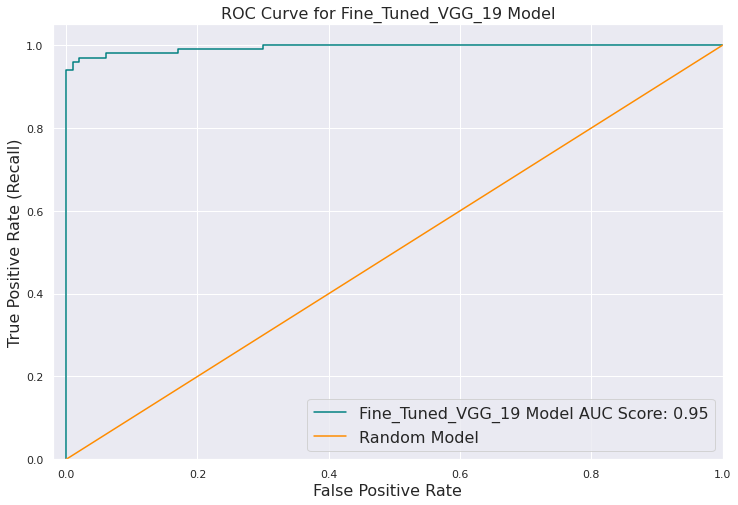

In [64]:
plot_roc_curve(y_true = y_test, y_pred = model_5_predictions, model_path = f'{model_5.name}.h5')

Let's call the function and make predictions on randomly selected female images.

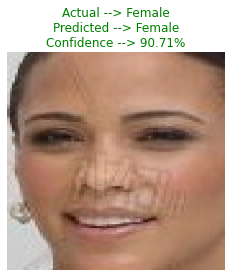

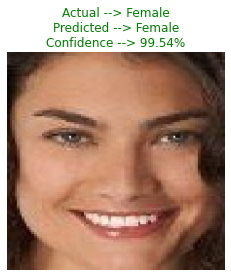

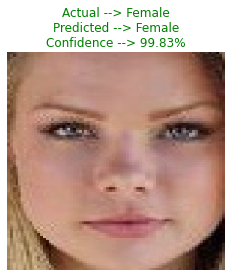

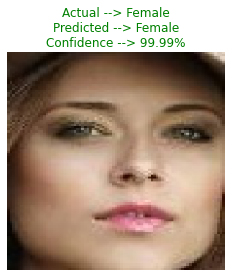

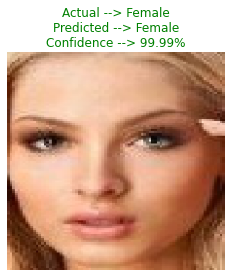

In [65]:
make_random_predictions(class_name = 'female', model_path = f'{model_5.name}.h5')

Let's call the function and make predictions on randomly selected male images.

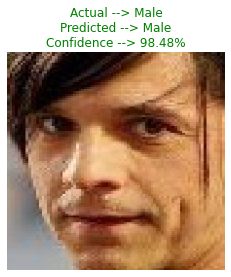

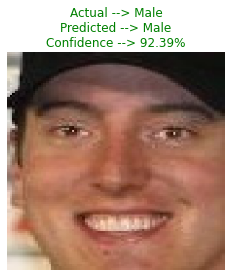

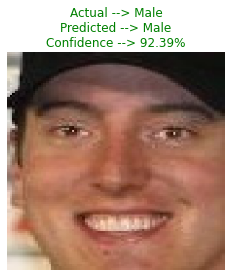

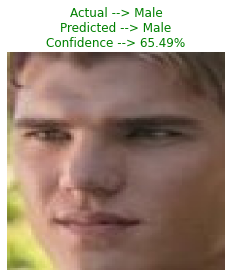

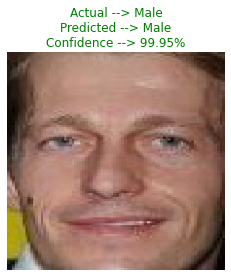

In [66]:
make_random_predictions(class_name = 'male', model_path = f'{model_5.name}.h5')

Let's call the function and evaluate the performance of the model.

In [67]:
model_5_df = evaluate_model_performance(y_true = y_test, y_pred = model_5_predictions, model_path = f'{model_5.name}.h5')
model_5_df

Train_Accuracy  ...  F1_Score
Fine_Tuned_VGG_19 Model            0.97  ...      0.95

[1 rows x 7 columns]

Let's compare all the models.

In [68]:
models_summary_df = pd.concat(objs = [model_1_df, model_2_df, model_3_df, model_4_df, model_5_df], axis = 0)
models_summary_df.sort_values(by = 'Test_Accuracy', ascending = False, inplace = True)
models_summary_df

Train_Accuracy  ...  F1_Score
Feature_Extraction_Resnet_50 Model            0.91  ...      0.96
Fine_Tuned_VGG_19 Model                       0.97  ...      0.95
Feature_Extraction_VGG_19 Model               0.95  ...      0.93
Sequential_CNN Model                          0.50  ...      0.00
Functional_CNN Model                          0.51  ...      0.00

[5 rows x 7 columns]

Let's define a function to make predictions on custom image.

In [69]:
def make_predictions(filepath, custom_objects = None, model_path = None):
  """
  This is a function that will make prediction on custom image.

  Args:
    filepath: A path to an image.
    custom_objects: A dictionary object to pass an unknown layer.
    model_path: A path to a model instance.
  
  Returns:
    Image with ground truth, predicted label and confidence.
  """
  model = load_model(filepath = model_path, custom_objects = custom_objects)
  loading_image = load_img(path = filepath, target_size = (224, 224))
  converting_into_array = img_to_array(img = loading_image)
  expanding_dimensions = np.expand_dims(a = converting_into_array, axis = 0)
  preprocessed_image = expanding_dimensions / 255.0

  predicted_class = tf.cast(x = tf.math.round(x = tf.squeeze(input = model.predict(x = preprocessed_image))), dtype = tf.int32).numpy()
  predicted_proba = tf.squeeze(input = model.predict(x = preprocessed_image)).numpy()
  predicted_label = LABEL_DICTIONARY[predicted_class].capitalize()
  actual_label = filepath.split('.')[0].capitalize()

  if predicted_class == 1:
    if predicted_label == actual_label:
      plt.imshow(X = loading_image)
      plt.title(label = f'Actual --> {actual_label}\nPredicted --> {predicted_label}\nConfidence --> {predicted_proba:.2%}', c = 'green')
      plt.axis('off')
      plt.show()
      print()
    else:
      plt.imshow(X = loading_image)
      plt.title(label = f'Actual --> {actual_label}\nPredicted --> {predicted_label}\nConfidence --> {predicted_proba:.2%}', c = 'red')
      plt.axis('off')
      plt.show()
      print()
  else:
    if predicted_label == actual_label:
      plt.imshow(X = loading_image)
      plt.title(label = f'Actual --> {actual_label}\nPredicted --> {predicted_label}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'green')
      plt.axis('off')
      plt.show()
      print()
    else:
      plt.imshow(X = loading_image)
      plt.title(label = f'Actual --> {actual_label}\nPredicted --> {predicted_label}\nConfidence --> {1.0 - predicted_proba:.2%}', c = 'red')
      plt.axis('off')
      plt.show()
      print()

Let's make predictions on custom images.

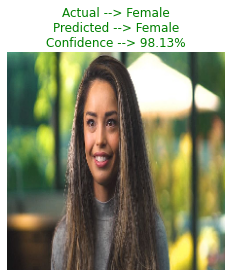

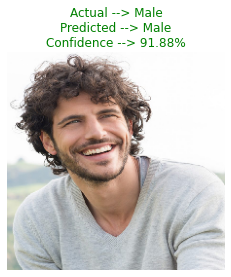

In [70]:
image_paths = ['female.jpg', 'male.jpg']

for image_path in image_paths:
  make_predictions(filepath = image_path, custom_objects = CUSTOM_OBJECTS, model_path = f'{model_3.name}.h5')

Let's download the Resnet 50 Feature Extraction model.

In [71]:
download(filename = f'{model_3.name}.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>